### vLLM trial --FAILED


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformers
import torch

model_id = "amazon/MistralLite"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.float16,
                                             use_flash_attention_2=True,
                                             device_map="auto",)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)
prompt = "<|prompter|>What are the main challenges to support a long context for LLM?</s><|assistant|>"

sequences = pipeline(
    prompt,
    max_new_tokens=400,
    do_sample=False,
    return_full_text=False,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)
for seq in sequences:
    print(f"{seq['generated_text']}")

ValueError: Tokenizer class LlamaTokenizer does not exist or is not currently imported.

## GPT 3.5 16k trial

In [ ]:
from openai import OpenAI
client = OpenAI(api_key = '<insert API key here>' )        # key removed for privacy, use appropriate key here
import time

In [ ]:
import os
import glob
import pandas as pd

directory_path = 'Patients_Datewise_Texts_With_First_Occurance'

csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

In [ ]:
df = dfs[2]

,CHARTDATE,TEXT,FIRST_OCCURANCE
0,2123-08-23,[**2123-8-23**] 12:30 PM\n CHEST (PORTABLE AP)...,0
1,2123-08-24,Smicu nsg admission note\n65 women recently dx...,0
2,2123-08-25,[**2123-8-25**] 9:02 PM\n CHEST (PORTABLE AP) ...,0
3,2123-08-26,[**2123-8-26**] 2:17 PM\n MR HEAD W & W/O CONT...,0


In [ ]:
df

,CHARTDATE,TEXT,FIRST_OCCURANCE
0,2123-08-23,[**2123-8-23**] 12:30 PM\n CHEST (PORTABLE AP)...,0
1,2123-08-24,Smicu nsg admission note\n65 women recently dx...,0
2,2123-08-25,[**2123-8-25**] 9:02 PM\n CHEST (PORTABLE AP) ...,0
3,2123-08-26,[**2123-8-26**] 2:17 PM\n MR HEAD W & W/O CONT...,0
4,2123-08-27,[**2123-8-27**] 12:51 AM\n CHEST (PORTABLE AP)...,0
5,2123-08-29,[**2123-8-29**] 2:32 PM\n CHEST (PA & LAT); CH...,0
6,2123-08-30,[**2123-8-30**] 6:18 PM\n CHEST (PORTABLE AP) ...,0
7,2123-08-31,[**2123-8-31**] 10:57 AM\n CHEST (PORTABLE AP)...,0
8,2123-09-01,[**2123-9-1**] 7:09 AM\n CHEST (PORTABLE AP) ...,0
9,2123-09-02,[**2123-9-2**] 8:33 AM\n CHEST (PORTABLE AP) ...,0


In [1]:
import re
import os
import glob
import pandas as pd
from tqdm import tqdm

In [ ]:
directory_path = 'Patients_Datewise_Texts_With_First_Occurance'

csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
dfs = []

already_saved = glob.glob(os.path.join('patients_datewise_gpt35', '*.csv'))

for csv_file in tqdm(csv_files):
    out_filename = 'gpt35_16k_' + csv_file.split('\\')[-1]
    if os.path.join('patients_datewise_gpt35', out_filename) in already_saved:
        continue
    
    df = pd.read_csv(csv_file)
    res, summaries, answers = [], [], []
    summary = ''
    token_len_exceeded_error = False
    for i, row in df.iterrows():
        try:
            text = 'Prior patient reports summary: ' + summary + '\nCurrent report:\n' + row['TEXT']
            start = time.time()
            completion = client.chat.completions.create(
                model="gpt-3.5-turbo-1106",
                messages=[
                    {"role": "system", "content": "You are an assistant for a medical practitioner, skilled in analyzing and summarizing medical notes and reports."},
                    {"role": "user", "content": text + ".\n Using the above medical notes, please give your diagnosis and also determine if the patient has pulmonary embolism. Summarize the report (start with Summary:), give your short diagnosis (start with Diagnosis:), and answer the pulmonary embolism question only with a yes or no. If pulmonary embolism cannot be established, please say no and nothing more."},
                ]
            )
            gentime = time.time() - start
            ans = completion.choices[0].message.content
            pattern = re.compile(r'Summary:(.*?)(?:Pulmonary embolism:)(.*)', re.DOTALL | re.IGNORECASE)
            summary_match = pattern.search(ans)
            summary = summary_match.group(1).strip() if summary_match else summary
            summaries.append(summary)

            # pe_match = re.search(r'Pulmonary Embolism: (.*)', ans, re.IGNORECASE)
            pe_text = summary_match.group(2).strip() if summary_match else ""
            res.append(pe_text)
            answers.append(ans)
            # print(ans, '\n', gentime)
        except Exception as e:
            print(e)
            token_len_exceeded_error = True
            break

    if token_len_exceeded_error:
        continue

    try:
        assert len(res) == len(df) == len(summaries) == len(answers), 'Lengths mismatch'
    except AssertionError:
        continue
    
    df['Summary'] = summaries
    df['PE_Result_GPT35_16k'] = res
    df['Answers'] = answers
    
    df.to_csv('patients_datewise_gpt35/' + out_filename, index=False)

In [4]:
directory_path = 'patients_datewise_gpt35/'

csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
dfs = []

already_saved = glob.glob(os.path.join('patients_datewise_gpt35', '*.csv'))

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

In [32]:
print(dfs[3]["TEXT"].iloc[13])

[**2113-10-13**] 7:47 AM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 76791**]
 Reason: evaluate for interval changes
 Admitting Diagnosis: CHEST PAIN
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  65 year old woman with CHF s/p extubation and chest tube removal
 REASON FOR THIS EXAMINATION:
  evaluate for interval changes
 ______________________________________________________________________________
                                 FINAL REPORT
 TECHNIQUE:  Semi-erect portable radiograph of chest.

 Comparisons were made with prior chest radiographs through [**2113-10-3**],
 with most recent from [**2113-10-12**].

 FINDINGS:  There are no interval relevant changes since [**2113-10-12**].
 Right internal jugular line ends at lower SVC.  Right chest tube is stable in
 position.  No demonstrable pneumothorax.  Minimal right pleural effusion,
 bibasal lung atelec

In [16]:
print(dfs[3]["Answers"].iloc[2])

Summary:
The patient, a 64-year-old woman with COPD, CAD, depression, and CHF, presented with low-grade fever, chronic cough, and respiratory distress. Imaging studies revealed findings consistent with dilated cardiomyopathy, left ventricular dysfunction, and possible mitral valve abnormalities. Additionally, the patient exhibited findings indicative of right heart failure and multifocal pneumonia, including moderate pulmonary artery systolic hypertension and prominent septal lines suggesting mild pulmonary edema. There was no evidence of pulmonary embolism.

Diagnosis:
The patient's findings are consistent with dilated cardiomyopathy, left ventricular dysfunction, possible mitral valve abnormalities, right heart failure, and multifocal pneumonia.

Pulmonary Embolism:
No


In [15]:
print(dfs[3]["TEXT"].iloc[2])

[**2113-10-1**] 9:59 AM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 77129**]
 Reason: please eval for pna, masses. The patient is febrile with a c
 Admitting Diagnosis: CHEST PAIN
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  64 year old woman with COPD, CAD, depression, CHF now with low grade fever and
  chronic cough.
 REASON FOR THIS EXAMINATION:
  please eval for pna, masses. The patient is febrile with a cough (dx of COPD)
 ______________________________________________________________________________
                                 FINAL REPORT
 CLINICAL HISTORY:  COPD, CHF, now with low-grade fevers.

 CHEST AP:

 The heart shows some left ventricular prominence and calcification of the
 aorta.  The diaphragms are somewhat flattened, consistent with known COPD.  No
 acute lung process is identified.  No evidence of failure or pneumonia is
 seen.

 Ther

In [9]:
print(dfs[2]["TEXT"].iloc[0])

[**2182-6-10**] 12:35 PM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 1618**]
 Reason: r/o pneumonia
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  42 year old woman with hypoxia, altered mental status
 REASON FOR THIS EXAMINATION:
  r/o pneumonia
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  Hypoxia, altered mental status.

 CHEST X-RAY, PORTABLE AP:  There are no prior films for comparison.  The film
 is significantly degraded by motion artifact. The lung volumes are low.  There
 is possible increased opacity in the left retrocardiac region, which may
 represent atelectasis versus infiltrate.  The right lung demonstrates
 increased lucency with respect to the left.  A line is visible at the right
 lateral lower lung zone, which may signify a small pneumothorax.

 IMPR

In [7]:
print(dfs[2]["Answers"].iloc[0])

Summary:
The 42-year-old female patient presents with hypoxia, altered mental status, distended abdomen, hypotension, and fever. The initial chest X-ray reveals possible atelectasis versus infiltrate in the left retrocardiac region, and a possible right pneumothorax is identified, prompting a recommendation for repeat imaging. The abdominal X-ray shows a non-specific bowel gas pattern. A subsequent CTA chest with contrast identifies occlusive and non-occlusive pulmonary emboli, bilateral wedge-shaped areas of consolidation, patchy ground glass opacities, enlarged lymph nodes, and a splenic infarct.

Diagnosis:
The patient presents with a complex clinical picture suggestive of multiple potential diagnoses, including possible pulmonary embolism, tracheomalacia, autoimmune or inflammatory lung pathology, and splenic infarct. Further evaluation and differential diagnosis are warranted.

Pulmonary embolism:
Yes


In [22]:
print(dfs[11]["TEXT"].iloc[2])

Thromboembolism, other
   Assessment:
   Action:
   Response:
   Plan:
   Tachycardia, Other
   Assessment:
   HR: 118-130s, no ectopy noted
   Action:
   Given 1 500ml FB for tachycardia
   Response:
   Mild improvement noted
   Plan:
   Continue to monitor HR, ?need for additional fluids
 48 y/o m, hx AML dx [**4-14**], s/p allo BMT [**2116-8-25**], s/p BAL [**10-24**] and VATs
   [**11-4**]
   Presented to onc clinic after 2 days facial, neck and upper arm
   swelling, 2 syncopal episodes en route to clinic, chest ct revealed
   clot in SVC, IR sheath via Hickman placed and TPA infusion initiated
   Thromboembolism, other
   Assessment:
   +2 upper extremity and facial edema, radial pulses easily palpable,
   returned to IR [**2-1**] in am, clot in lower half of SVC now patent and but
   upper half still thrombosed, sheath repositioned, tpa infusion
   continued
   Action:
   Continues tpa and heparin infusions, unable to get q6hr labs,
   venipuncture contraindicated, insufficient 

In [23]:
print(dfs[11]["Answers"].iloc[2])

Summary:
The 48-year-old male with a history of acute myeloid leukemia (AML) post-allogeneic bone marrow transplant (BMT) presented with facial swelling, syncope, and left arm swelling. CT imaging revealed a large thrombus within the superior vena cava (SVC) consistent with SVC syndrome. Thrombolysis of the SVC clot was performed, and the patient remained hemodynamically stable with no signs of bleeding. The patient also had a small pericardial effusion and mild pulmonary artery hypertension noted on echocardiography. The patient was monitored for tachycardia and received fluid boluses for improvement.

Diagnosis:
Superior vena cava syndrome with a large nearly occlusive thrombus within the SVC and small offshoot into the left brachiocephalic vein. Small pericardial effusion without tamponade physiology. Mild pulmonary artery hypertension. Tachycardia.

Pulmonary Embolism:
Yes


In [27]:
print(dfs[20]["TEXT"].iloc[2])

[**2104-11-4**] 3:19 PM
 CT CHEST W/CONTRAST                                             Clip # [**Clip Number (Radiology) 76380**]
 Reason: question of sarcoidosis
 Admitting Diagnosis: LEG WEAKNESS
  Contrast: OPTIRAY Amt: 65
 ______________________________________________________________________________
 [**Hospital 4**] MEDICAL CONDITION:
  66 year old man with chronic back pain, lesions in brain and paraparesis
 REASON FOR THIS EXAMINATION:
  question of sarcoidosis
 No contraindications for IV contrast
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  66-year-old male with chronic back pain, brain lesions and
 paraparesis.  Question of sarcoidosis.

 TECHNIQUE:  CT of the chest with IV contrast.

 FINDINGS:  There is no axillary or mediastinal or hilar lymphadenopathy. There
 is no pericardial effusion.  The heart is of normal size.  There are
 calcifications of the aortic valve, which can b

In [28]:
print(dfs[20]["Answers"].iloc[2])

Summary:
The 66-year-old male patient presented with chronic back pain, brain lesions, and paraparesis, with a question of sarcoidosis. Imaging studies included a CT chest with contrast and an MRI of the cervical spine. The CT chest findings revealed no evidence of sarcoidosis but indicated the presence of a pulmonary embolism, calcification of the aortic valve, and a gallstone. The MRI of the cervical spine showed extensive changes of cervical spondylosis and disc herniation at C6-C7 level. Additionally, a transthoracic echocardiogram revealed multiple cardiovascular abnormalities, including left ventricular hypokinesis and aortic dilation.

Diagnosis:
The patient's medical history and imaging findings indicate chronic back pain, paraparesis, extensive cervical spondylosis, disc herniation at C6-C7 level, and multiple cardiovascular abnormalities, including left ventricular hypokinesis and aortic dilation.

Pulmonary Embolism:
Yes


In [ ]:
# df.drop(columns=['Summary', 'PE_Result_GPT35_16k', 'Answers'], inplace=True)
# df.head(2)

In [ ]:
# start = time.time()
# completion = client.chat.completions.create(
#   model="gpt-3.5-turbo",
#   messages=[
#     {"role": "system", "content": "You are an assistant for a medical practitioner, skilled in analyzing and summarizing medical notes and reports."},
#     {"role": "user", "content": "f{} Using the above medical notes, please give your diagnosis and also determine if the patient has pulmonary embolism. Keep your diagnosis short, and answer the pulmonary embolism question with a yes or no."},
#   ]
# )
# gentime = time.time() - start
# print(completion.choices[0].message, '\n', gentime)

ChatCompletionMessage(content="In the realm of code, where logic pervades,\nI'll weave a tale of a looping crusade.\nA concept profound, yet elegantly clear,\nRecursion, dear friends, is what we shall hear.\n\nImagine a function, a humble charmer,\nWhose power lies not in its initial armor.\nA call, it makes, to itself with grace,\nLike mirrors reflecting, within time and space.\n\nA seed of thought, a problem to unravel,\nEach iteration, a layer to travel.\nWith each recursion, it breaks it down,\nInto smaller fragments, truth shall be found.\n\nA fractal of code, a path untold,\nExpanding dimensions, behold, behold!\nIt dances with grace, in a mystical trance,\nUnraveling the puzzle, giving it a chance.\n\nLike an echo resounding, back and forth,\nIt explores the labyrinth, south, east, and north.\nWith keen observation, it scrutinizes,\nUnraveling mysteries, solving the prizes.\n\nBut beware, my friends, for recursion can be sly,\nCaught in a loop, it may make you cry.\nAn end condi

In [34]:
dfs[11]

,CHARTDATE,TEXT,FIRST_OCCURANCE,Summary,PE_Result_GPT35_16k,Answers
0,2117-01-31,[**2117-1-31**] 11:16 AM\n CHEST (PORTABLE AP)...,0,A 48-year-old male with AML status post-allogr...,No,Summary:\nA 48-year-old male with AML status p...
1,2117-02-01,"Thromboembolism, other\n Assessment:\n Thi...",0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
2,2117-02-02,"Thromboembolism, other\n Assessment:\n Act...",0,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
3,2117-02-03,"48 y/o m, hx AML dx [**4-14**], s/p allo BMT [...",0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
4,2117-02-04,[**2117-2-4**] 11:09 AM\n CHEST (PORTABLE AP) ...,0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
5,2117-02-05,[**2117-2-5**] 3:16 PM\n CHEST (PORTABLE AP) ...,0,The 48-year-old male with a history of acute m...,No.,Summary:\nThe 48-year-old male with a history ...
6,2117-02-06,PATIENT/TEST INFORMATION:\nIndication: Pericar...,0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
7,2117-02-07,[**2117-2-7**] 11:43 AM\n CTA CHEST W&W/O C&RE...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
8,2117-02-08,[**2117-2-8**] 1:26 PM\n BILAT LOWER EXT VEINS...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
9,2117-02-09,Sinus tachycardia\nNondiagnostic lateral q wav...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...


In [37]:
# directory_path = 'patients_datewise_gpt35/'

# csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
# dfs = []

already_saved = glob.glob(os.path.join('patients_datewise_gpt35', '*.csv'))

patient_ids = []

dfs_new = []
for csv_file in csv_files:
    patient_ids.append(csv_file.split('_')[-2] + ' ' + csv_file.split('_')[-1].split('.')[0])
    df = pd.read_csv(csv_file)
    dfs_new.append(df)

In [38]:
dfs[11]

,CHARTDATE,TEXT,FIRST_OCCURANCE,Summary,PE_Result_GPT35_16k,Answers
0,2117-01-31,[**2117-1-31**] 11:16 AM\n CHEST (PORTABLE AP)...,0,A 48-year-old male with AML status post-allogr...,No,Summary:\nA 48-year-old male with AML status p...
1,2117-02-01,"Thromboembolism, other\n Assessment:\n Thi...",0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
2,2117-02-02,"Thromboembolism, other\n Assessment:\n Act...",0,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
3,2117-02-03,"48 y/o m, hx AML dx [**4-14**], s/p allo BMT [...",0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
4,2117-02-04,[**2117-2-4**] 11:09 AM\n CHEST (PORTABLE AP) ...,0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
5,2117-02-05,[**2117-2-5**] 3:16 PM\n CHEST (PORTABLE AP) ...,0,The 48-year-old male with a history of acute m...,No.,Summary:\nThe 48-year-old male with a history ...
6,2117-02-06,PATIENT/TEST INFORMATION:\nIndication: Pericar...,0,The 48-year-old male with a history of acute m...,No,Summary:\nThe 48-year-old male with a history ...
7,2117-02-07,[**2117-2-7**] 11:43 AM\n CTA CHEST W&W/O C&RE...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
8,2117-02-08,[**2117-2-8**] 1:26 PM\n BILAT LOWER EXT VEINS...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...
9,2117-02-09,Sinus tachycardia\nNondiagnostic lateral q wav...,1,The 48-year-old male with a history of acute m...,Yes,Summary:\nThe 48-year-old male with a history ...


In [40]:
patient_ids[3]

'2639 157999'

## Deevanshu read this!

In [1]:
import os
import glob
import pandas as pd
directory_path = 'patients_datewise_gpt35_negation_handled_pe/'

csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
patient_ids = []
dfs = []
for csv_file in csv_files:
    patient_ids.append(csv_file.split('_')[-2] + ' ' + csv_file.split('_')[-1].split('.')[0])
    df = pd.read_csv(csv_file).drop(columns=['FIRST_OCCURANCE'])
    dfs.append(df)

In [2]:
len(dfs)

428

In [189]:
dfs[0]

,CHARTDATE,TEXT,Summary,PE_Result_GPT35_16k,Answers,FIRST_OCCURRENCE_CORRECTED
0,2123-12-24,[**2123-12-24**] 6:06 PM\n CHEST (PORTABLE AP)...,The patient is a 77-year-old woman presenting ...,No.,Summary:\nThe patient is a 77-year-old woman p...,0
1,2123-12-25,MICU NPN Admit note\n\nPt is 77y/o who was tra...,The 77-year-old female patient presented with ...,No.,Summary:\nThe 77-year-old female patient prese...,0
2,2123-12-26,"NPN 7a-7p\n\n\n\nNeuro: A&Ox3, slept on and of...",The 77-year-old female patient presented with ...,No,Summary:\nThe 77-year-old female patient prese...,0
3,2123-12-27,[**2123-12-27**] 9:56 AM\n CHEST (PA & LAT) ...,The 77-year-old female patient presented with ...,No,Summary:\nThe 77-year-old female patient prese...,0
4,2123-12-29,[**2123-12-29**] 2:36 AM\n CHEST (PORTABLE AP)...,The 77-year-old female patient presented with ...,NaN,Summary:\nThe 77-year-old female patient prese...,1
5,2123-12-30,NSG NOTE\n\nCV: HR 87-93. NSR NO VEA NOTED. S...,The 77-year-old female patient has a complex m...,No,Summary:\nThe 77-year-old female patient has a...,1
6,2123-12-31,CCU Nursing Progress Note\nS: Intubated\n\nO: ...,The 77-year-old female patient has a complex m...,"Yes\n\nBased on the medical notes, the patient...",Summary:\nThe 77-year-old female patient has a...,1
7,2124-01-01,NSG NOTE\n\nCV: REMAINS IN NSR WITH HR 87-92. ...,The 77-year-old female patient has a complex m...,No\n\nThe report does not indicate the presenc...,Summary:\nThe 77-year-old female patient has a...,1
8,2124-01-02,Micu Nursing Acceptance note:\n\nPt transferre...,The 77-year-old female patient has a complex m...,No,Summary:\nThe 77-year-old female patient has a...,1
9,2124-01-03,Micu Nursing Progress Note:\n\nNeuro: awake an...,The 77-year-old female patient has a complex m...,NaN,Summary:\nThe 77-year-old female patient has a...,1


In [6]:
filtered_dfs = []
unique_ids = []
count = 0
freq = {}
for i, df in enumerate(dfs):
    try:
        index_of_fo = (df['FIRST_OCCURRENCE_CORRECTED'] == 1).idxmax()
        index_of_fpred = df['PE_Result_GPT35_16k'].str.upper().eq('YES').idxmax() if any(df['PE_Result_GPT35_16k'].str.upper().eq('YES')) else float('inf')
        if(index_of_fo > index_of_fpred):
            filtered_dfs.append((patient_ids[i], df))
            unique_ids.append(patient_ids[i])
            diff = index_of_fo - index_of_fpred
            if diff in freq:
                freq[diff] += 1
            else:
                freq[diff] = 1
    except:
        count += 1
        continue

In [8]:
unique_ids

['47286 155315',
 '23291 103175',
 '20965 133030',
 '28636 141318',
 '47731 152340',
 '1949 122008',
 '3181 181599',
 '22674 107142',
 '22330 136390',
 '21397 100792',
 '12968 126751',
 '28623 152544',
 '43149 108346',
 '12805 151145',
 '15624 192513',
 '3007 128949',
 '4851 130396',
 '27672 184680',
 '21202 194067',
 '22034 175438',
 '10017 199207',
 '22076 154613',
 '40867 148920',
 '23411 172206',
 '31141 171547',
 '12183 180744',
 '3941 196745',
 '48388 156310',
 '24109 155286',
 '23130 154351',
 '45291 144991',
 '16985 138680',
 '47693 188536',
 '29123 185864',
 '3192 150709']

In [18]:
unique_ids_2 = [str(x.split(" ")[0])+"_"+str(x.split(" ")[1]) for x in unique_ids]
unique_ids_2

['47286_155315',
 '23291_103175',
 '20965_133030',
 '28636_141318',
 '47731_152340',
 '1949_122008',
 '3181_181599',
 '22674_107142',
 '22330_136390',
 '21397_100792',
 '12968_126751',
 '28623_152544',
 '43149_108346',
 '12805_151145',
 '15624_192513',
 '3007_128949',
 '4851_130396',
 '27672_184680',
 '21202_194067',
 '22034_175438',
 '10017_199207',
 '22076_154613',
 '40867_148920',
 '23411_172206',
 '31141_171547',
 '12183_180744',
 '3941_196745',
 '48388_156310',
 '24109_155286',
 '23130_154351',
 '45291_144991',
 '16985_138680',
 '47693_188536',
 '29123_185864',
 '3192_150709']

In [60]:
admission_df = pd.read_csv('ADMISSIONS.csv')
patients_df = pd.read_csv('PATIENTS.csv')

patients_df

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,1,2,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,4,5,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
3,6,7,F,2121-05-23 00:00:00,NaN,NaN,NaN,0
4,7,8,M,2117-11-20 00:00:00,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
23687,30793,32802,F,2126-01-28 00:00:00,NaN,NaN,NaN,0
23688,30794,32803,F,2118-02-06 00:00:00,NaN,NaN,NaN,0
23689,30797,32806,M,2162-10-22 00:00:00,NaN,NaN,NaN,0
23690,30798,32807,M,2092-10-22 00:00:00,NaN,NaN,NaN,0


In [61]:
patients_df[patients_df['subject_id']==47731]


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag


In [62]:
admission_df['unique_id'] = admission_df['SUBJECT_ID'].astype(str)+'_'+admission_df['HADM_ID'].astype(str)
admission_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,unique_id
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,22_165315
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,23_152223
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,23_124321
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,24_161859
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,25_129635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,98800_191113
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,98802_101071
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1,98805_122631
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,98813_170407


In [63]:
subset_df = admission_df[admission_df['unique_id'].isin(unique_ids_2)]
subset_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,unique_id
2188,2350,1949,122008,2128-03-20 01:03:00,2128-03-25 16:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,NaN,NOT SPECIFIED,NaN,WHITE,2128-03-19 21:44:00,2128-03-20 02:05:00,CARDIAC ARREST,0,1,1949_122008
3172,3616,3007,128949,2189-04-29 20:16:00,2189-05-18 13:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Private,NaN,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,ACUTE MYOCARDIAL INFARCTION;TELEMETRY\ANGIOPLASTY,0,1,3007_128949
3746,3849,3192,150709,2146-11-29 15:35:00,2146-12-13 18:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,NaN,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2146-11-29 10:09:00,2146-11-29 17:10:00,PULMONARY EMBOLISM;TELEMETRY,0,1,3192_150709
4102,3835,3181,181599,2120-08-11 06:57:00,2120-08-21 14:24:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NaN,MARRIED,UNKNOWN/NOT SPECIFIED,2120-08-11 02:50:00,2120-08-11 06:58:00,SHORTNESS OF BREATH-PULMONARY EMBOLISM,0,1,3181_181599
4935,4759,3941,196745,2176-12-06 03:06:00,2177-01-02 14:40:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2176-12-05 15:31:00,2176-12-06 04:15:00,UROSEPSIS,0,1,3941_196745
8208,5879,4851,130396,2129-03-11 11:41:00,2129-03-16 16:33:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,WIDOWED,WHITE,NaN,NaN,PULMONARY EMBOLI,0,1,4851_130396
11611,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,10017_199207
14765,14975,12183,180744,2197-05-27 20:50:00,2197-06-08 18:15:00,2197-06-08 18:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,2197-05-27 20:02:00,2197-05-27 22:12:00,CONGESTIVE HEART FAILURE,1,1,12183_180744
16075,15896,12968,126751,2161-03-06 00:11:00,2161-03-19 13:51:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2161-03-05 20:31:00,2161-03-06 01:45:00,PULMONARY EMBOLISM,0,1,12968_126751
17227,15705,12805,151145,2181-10-20 02:12:00,2182-01-15 14:40:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,NaN,PROTESTANT QUAKER,NaN,WHITE,2181-10-19 19:05:00,2181-10-20 03:20:00,SEIZURE,0,1,12805_151145


In [64]:
result_df = pd.merge(subset_df, patients_df[['subject_id', 'dob', 'gender', 'expire_flag']], left_on='SUBJECT_ID', right_on='subject_id', how='left')
result_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,unique_id,subject_id,dob,gender,expire_flag
0,2350,1949,122008,2128-03-20 01:03:00,2128-03-25 16:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,2128-03-19 21:44:00,2128-03-20 02:05:00,CARDIAC ARREST,0,1,1949_122008,1949.0,2064-01-23 00:00:00,F,1.0
1,3616,3007,128949,2189-04-29 20:16:00,2189-05-18 13:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Private,...,NaN,NaN,ACUTE MYOCARDIAL INFARCTION;TELEMETRY\ANGIOPLASTY,0,1,3007_128949,3007.0,2142-01-09 00:00:00,M,0.0
2,3849,3192,150709,2146-11-29 15:35:00,2146-12-13 18:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,2146-11-29 10:09:00,2146-11-29 17:10:00,PULMONARY EMBOLISM;TELEMETRY,0,1,3192_150709,NaN,NaN,NaN,NaN
3,3835,3181,181599,2120-08-11 06:57:00,2120-08-21 14:24:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2120-08-11 02:50:00,2120-08-11 06:58:00,SHORTNESS OF BREATH-PULMONARY EMBOLISM,0,1,3181_181599,3181.0,2041-06-23 00:00:00,M,1.0
4,4759,3941,196745,2176-12-06 03:06:00,2177-01-02 14:40:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2176-12-05 15:31:00,2176-12-06 04:15:00,UROSEPSIS,0,1,3941_196745,3941.0,2100-01-19 00:00:00,M,1.0
5,5879,4851,130396,2129-03-11 11:41:00,2129-03-16 16:33:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,NaN,NaN,PULMONARY EMBOLI,0,1,4851_130396,4851.0,2050-01-17 00:00:00,F,1.0
6,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,10017_199207,10017.0,2075-09-21 00:00:00,F,1.0
7,14975,12183,180744,2197-05-27 20:50:00,2197-06-08 18:15:00,2197-06-08 18:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,2197-05-27 20:02:00,2197-05-27 22:12:00,CONGESTIVE HEART FAILURE,1,1,12183_180744,NaN,NaN,NaN,NaN
8,15896,12968,126751,2161-03-06 00:11:00,2161-03-19 13:51:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,2161-03-05 20:31:00,2161-03-06 01:45:00,PULMONARY EMBOLISM,0,1,12968_126751,12968.0,2094-03-14 00:00:00,M,1.0
9,15705,12805,151145,2181-10-20 02:12:00,2182-01-15 14:40:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,...,2181-10-19 19:05:00,2181-10-20 03:20:00,SEIZURE,0,1,12805_151145,12805.0,2147-08-05 00:00:00,F,0.0


In [65]:
result_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'unique_id',
       'subject_id', 'dob', 'gender', 'expire_flag'],
      dtype='object')

In [66]:
columns_to_drop = ['ROW_ID', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'subject_id']
result_df = result_df.drop(columns=columns_to_drop)

In [67]:
result_df

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,unique_id,dob,gender,expire_flag
0,1949,122008,2128-03-20 01:03:00,EMERGENCY,1949_122008,2064-01-23 00:00:00,F,1.0
1,3007,128949,2189-04-29 20:16:00,EMERGENCY,3007_128949,2142-01-09 00:00:00,M,0.0
2,3192,150709,2146-11-29 15:35:00,EMERGENCY,3192_150709,NaN,NaN,NaN
3,3181,181599,2120-08-11 06:57:00,EMERGENCY,3181_181599,2041-06-23 00:00:00,M,1.0
4,3941,196745,2176-12-06 03:06:00,EMERGENCY,3941_196745,2100-01-19 00:00:00,M,1.0
5,4851,130396,2129-03-11 11:41:00,EMERGENCY,4851_130396,2050-01-17 00:00:00,F,1.0
6,10017,199207,2149-05-26 17:19:00,EMERGENCY,10017_199207,2075-09-21 00:00:00,F,1.0
7,12183,180744,2197-05-27 20:50:00,EMERGENCY,12183_180744,NaN,NaN,NaN
8,12968,126751,2161-03-06 00:11:00,EMERGENCY,12968_126751,2094-03-14 00:00:00,M,1.0
9,12805,151145,2181-10-20 02:12:00,EMERGENCY,12805_151145,2147-08-05 00:00:00,F,0.0


In [68]:
import numpy as np

result_df['ADMITTIME'] = pd.to_datetime(result_df['ADMITTIME'])
result_df['dob'] = pd.to_datetime(result_df['dob'])

result_df['Birth_Year'] = result_df['dob'].dt.year
result_df['Admit_Year'] = result_df['ADMITTIME'].dt.year

# result_df['Age'] = np.nan
# mask = ~result_df['dob'].isnull() & ~result_df['ADMITTIME'].isnull()
# result_df.loc[mask, 'Age'] = (result_df['ADMITTIME'].year - result_df['dob'].year)


# result_df['Age'] = ((result_df['ADMITTIME'] - result_df['dob']) / np.timedelta64(1, 'Y')).astype(int)
# ((df['Admit_date'] - df['Date_of_Birth']) / np.timedelta64(1, 'Y')).astype(int)
result_df

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,unique_id,dob,gender,expire_flag,Birth_Year,Admit_Year
0,1949,122008,2128-03-20 01:03:00,EMERGENCY,1949_122008,2064-01-23,F,1.0,2064.0,2128
1,3007,128949,2189-04-29 20:16:00,EMERGENCY,3007_128949,2142-01-09,M,0.0,2142.0,2189
2,3192,150709,2146-11-29 15:35:00,EMERGENCY,3192_150709,NaT,NaN,NaN,NaN,2146
3,3181,181599,2120-08-11 06:57:00,EMERGENCY,3181_181599,2041-06-23,M,1.0,2041.0,2120
4,3941,196745,2176-12-06 03:06:00,EMERGENCY,3941_196745,2100-01-19,M,1.0,2100.0,2176
5,4851,130396,2129-03-11 11:41:00,EMERGENCY,4851_130396,2050-01-17,F,1.0,2050.0,2129
6,10017,199207,2149-05-26 17:19:00,EMERGENCY,10017_199207,2075-09-21,F,1.0,2075.0,2149
7,12183,180744,2197-05-27 20:50:00,EMERGENCY,12183_180744,NaT,NaN,NaN,NaN,2197
8,12968,126751,2161-03-06 00:11:00,EMERGENCY,12968_126751,2094-03-14,M,1.0,2094.0,2161
9,12805,151145,2181-10-20 02:12:00,EMERGENCY,12805_151145,2147-08-05,F,0.0,2147.0,2181


In [69]:
result_df['Age'] = np.nan
mask = ~result_df['Birth_Year'].isnull() & ~result_df['Admit_Year'].isnull()
result_df.loc[mask, 'Age'] = (result_df['Admit_Year'] - result_df['Birth_Year'])

result_df

,SUBJECT_ID,HADM_ID,ADMITTIME,ADMISSION_TYPE,unique_id,dob,gender,expire_flag,Birth_Year,Admit_Year,Age
0,1949,122008,2128-03-20 01:03:00,EMERGENCY,1949_122008,2064-01-23,F,1.0,2064.0,2128,64.0
1,3007,128949,2189-04-29 20:16:00,EMERGENCY,3007_128949,2142-01-09,M,0.0,2142.0,2189,47.0
2,3192,150709,2146-11-29 15:35:00,EMERGENCY,3192_150709,NaT,NaN,NaN,NaN,2146,NaN
3,3181,181599,2120-08-11 06:57:00,EMERGENCY,3181_181599,2041-06-23,M,1.0,2041.0,2120,79.0
4,3941,196745,2176-12-06 03:06:00,EMERGENCY,3941_196745,2100-01-19,M,1.0,2100.0,2176,76.0
5,4851,130396,2129-03-11 11:41:00,EMERGENCY,4851_130396,2050-01-17,F,1.0,2050.0,2129,79.0
6,10017,199207,2149-05-26 17:19:00,EMERGENCY,10017_199207,2075-09-21,F,1.0,2075.0,2149,74.0
7,12183,180744,2197-05-27 20:50:00,EMERGENCY,12183_180744,NaT,NaN,NaN,NaN,2197,NaN
8,12968,126751,2161-03-06 00:11:00,EMERGENCY,12968_126751,2094-03-14,M,1.0,2094.0,2161,67.0
9,12805,151145,2181-10-20 02:12:00,EMERGENCY,12805_151145,2147-08-05,F,0.0,2147.0,2181,34.0


In [70]:
result_df['expire_flag'].value_counts()

expire_flag
1.0    14
0.0     7
Name: count, dtype: int64

In [89]:
import matplotlib.pyplot as plt

expire_flag_counts = result_df['expire_flag'].value_counts(dropna=False)

expire_flag_counts

expire_flag
1.0    14
NaN    14
0.0     7
Name: count, dtype: int64

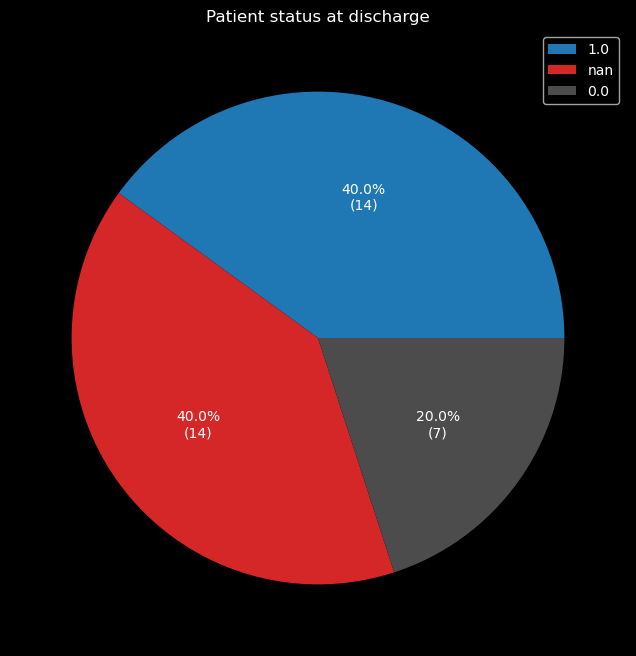

In [102]:
dark_colors = ['#1f77b4', '#d62728', '#4c4c4c']

legend_mapping = {0.0: 'Healthy', 1.0: 'Expired', np.nan: 'Data not available'}

# Convert index to list of strings, replacing NaN with a string
legend_labels = [legend_mapping.get(str(key), str(key)) for key in expire_flag_counts.index]

# Plot the pie chart with count labels and legend
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(expire_flag_counts, labels=expire_flag_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(expire_flag_counts)),
                                   colors=dark_colors, textprops=dict(color="w"))

# Customize the text labels
for text, autotext in zip(texts, autotexts):
    text.set_color('black')
    autotext.set_color('white')

# Add legend
plt.legend(legend_labels, loc='upper right')

plt.title('Patient status at discharge')
plt.show()

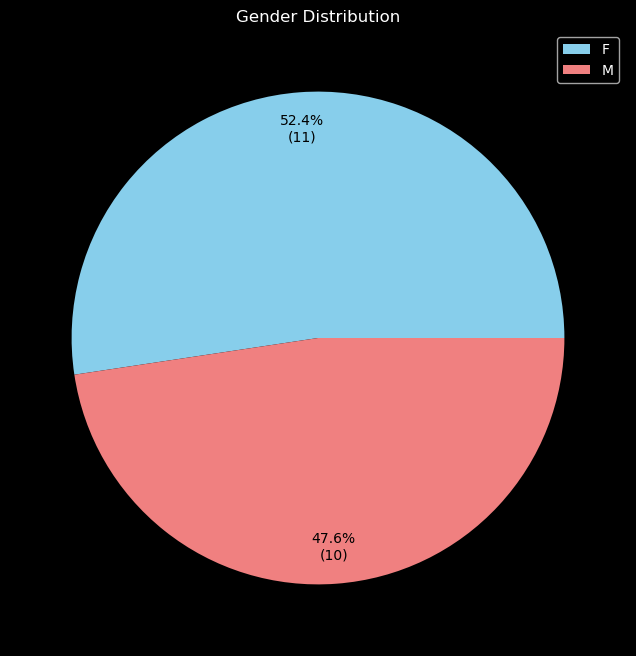

In [103]:
gender_counts = result_df['gender'].value_counts().dropna()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(gender_counts)),
        colors=['skyblue', 'lightcoral'], textprops=dict(color="black"), pctdistance=0.85)  # Set percentage distance
plt.title('Gender Distribution')
plt.legend()
plt.show()

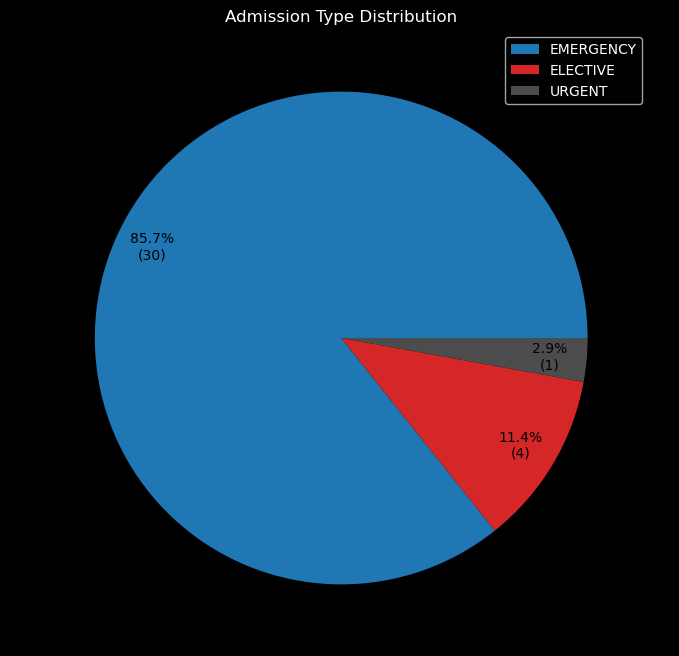

In [99]:
admission_type_counts = result_df['ADMISSION_TYPE'].value_counts()

dark_colors = ['#1f77b4', '#d62728', '#4c4c4c']
plt.figure(figsize=(8, 8))
plt.pie(admission_type_counts, labels=admission_type_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(admission_type_counts)),
        colors=dark_colors, textprops=dict(color="black"), pctdistance=0.85)  # Set percentage distance
plt.title('Admission Type Distribution')
plt.legend()
plt.show()

In [71]:
expire_flag_1_distribution = result_df[result_df['expire_flag'] == 1.0]['Age'].dropna()
overall_age_distribution = result_df['Age'].dropna()

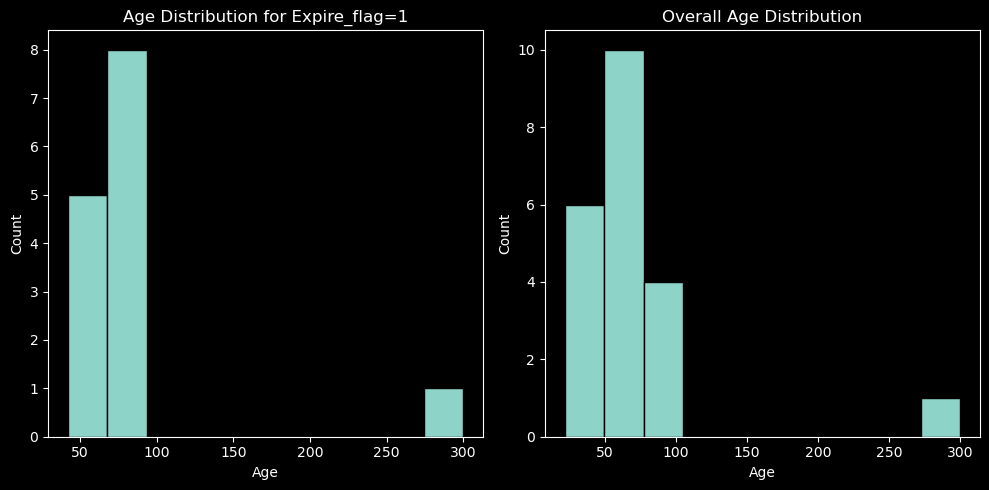

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
expire_flag_1_distribution.plot(kind='hist', bins=10, edgecolor='black')
plt.title('Age Distribution for Expire_flag=1')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
overall_age_distribution.plot(kind='hist', bins=10, edgecolor='black')
plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [77]:
expire_flag_1_distribution = result_df[(result_df['expire_flag'] == 1) & (result_df['Age'] < 300)]['Age'].dropna()

overall_age_distribution = result_df[(result_df['Age'] < 300)]['Age'].dropna()


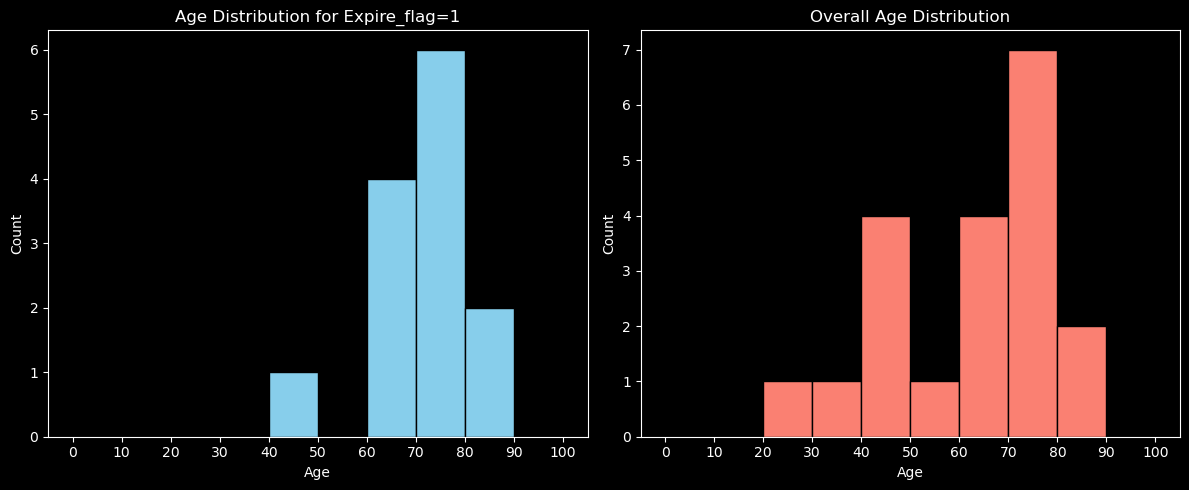

In [80]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
expire_flag_1_distribution.plot(kind='hist', bins=range(0, 110, 10), edgecolor='black', color = 'skyblue')
plt.title('Age Distribution for Expire_flag=1')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(range(0, 110, 10))  # Custom ticks for 10-year age groups

plt.subplot(1, 2, 2)
overall_age_distribution.plot(kind='hist', bins=range(0, 110, 10), edgecolor='black', color = 'salmon')
plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(range(0, 110, 10))  # Custom ticks for 10-year age groups

plt.tight_layout()
plt.show()

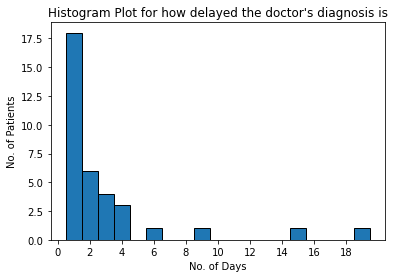

In [201]:
import matplotlib.pyplot as plt
import numpy as np

values = list(freq.keys())
counts = list(freq.values())

plt.bar(values, counts, width=1, edgecolor='black')

plt.xlabel('No. of Days')
plt.ylabel('No. of Patients')
plt.title("Histogram Plot for how delayed the doctor's diagnosis is")
plt.xticks(np.arange(0, max(values) + 1, step=2))

plt.show()

In [105]:
count

0

In [106]:
len(filtered_dfs)

35

In [204]:
filtered_dfs[-6][1]

,CHARTDATE,TEXT,Summary,PE_Result_GPT35_16k,Answers,FIRST_OCCURRENCE_CORRECTED
0,2111-10-05,[**2111-10-5**] 5:38 PM\n PULMONARY ANGIO ...,The patient is a 66-year-old woman with a hist...,Yes,Summary:\nThe patient is a 66-year-old woman w...,0
1,2111-10-06,Resp Care NOTE\n66 yo female adm. with lrg. PE...,The 66-year-old female patient with a history ...,Yes,Summary:\nThe 66-year-old female patient with ...,0
2,2111-10-07,PMICU NURSING PROGRESS NOTE\n\nCV/Resp: SBP 10...,The 66-year-old female patient with a history ...,Yes,Summary:\nThe 66-year-old female patient with ...,0
3,2111-10-08,"pmicu npn 7p-7a\n\n overall, pt had an uneve...",The 66-year-old female patient with a history ...,Yes,Summary:\nThe 66-year-old female patient with ...,0
4,2111-10-09,7p to 7a Micu Progress Note\n\nResp - pt initi...,The 66-year-old female patient with a history ...,Yes,Summary:\nThe 66-year-old female patient with ...,0
5,2111-10-10,Resp Care Note:\n\nPt cont intub on mech vent ...,The 66-year-old female patient with a history ...,Yes,Summary:\nThe 66-year-old female patient with ...,0
6,2111-10-11,Resp Care Note:\n\nPt cont intub on mech vent ...,The 66-year-old female patient with a history ...,No information regarding the presence of pulmo...,Summary:\nThe 66-year-old female patient with ...,0
7,2111-10-12,Resp Care Note:\n\nPt cont intub on mech vent ...,The 66-year-old female patient with a history ...,No.,Summary:\nThe 66-year-old female patient with ...,0
8,2111-10-13,Resp Care Note:\n\nPt cont intub on mech vent ...,"The 66-year-old female patient, with a history...",No,"Summary:\nThe 66-year-old female patient, with...",0
9,2111-10-14,Resp Care Note:\n\nPt cont intub on mech vent ...,"The 66-year-old female patient, with a history...",No,"Summary:\nThe 66-year-old female patient, with...",1


In [160]:
print(filtered_dfs[-6][1]["TEXT"].iloc[1])

Resp Care NOTE
66 yo female adm. with lrg. PE. Yesterday had thrombectomy,and 2 stents placed in PA. Return to MICU intubated,sedated, placed on AC 550x16/5/40%. BS: coarse however secreations have been minimal this shift.ABg's normal range, continue to wean o2 as tolerated. Pt. may return to CT and or MRI today.
 Pmicu Nursing progress Note:

Procedure: Pt returned from IR ~10:00. Pt intubated, aline placed in IR. Pt had pulmonary suction thrombectomy of small clot. Obstruction of main L PA was dilated and 2 stents placed for improved flow. IVC filter placed.  Became hypotensive post procedure after rec-ing lopressor. Was started on Neo gtt in IR.

CV: Pt arrived in MICU on 180mcg Neo gtt w/ SBP 80's HR 100-120's sinus. SBP cont'd to drop. Levophed gtt started. HR decreased slightly, and sbp stablized to sbp 90-100. Have since weaned neo gtt to 30mcg/min. Levophed remains on 8mcg/min. Heparin restarted on arrival. PTT  on arrival >150-> held for 1 hr and restarted per protocol. + bila

In [161]:
import pandas as pd

uids = ['3007_128949', '29123_185864', '48388_156310', '20965_133030', '31141_171547', '10017_199207', '28623_152544', '28636_141318']


In [162]:
dfs = []
for uid in uids:
    df = pd.read_csv('patients_datewise_gpt35_negation_handled_pe/' + 'fo_gpt35_16k_fo_text_' + str(uid) + '.csv').drop(columns=['FIRST_OCCURANCE'])
    dfs.append(df)

In [184]:
dfs[7]

,CHARTDATE,TEXT,Summary,PE_Result_GPT35_16k,Answers,FIRST_OCCURRENCE_CORRECTED
0,2101-10-05,Sinus tachycardia. Deep T wave inversions in l...,The patient's ECG indicates sinus tachycardia ...,No,Summary:\nThe patient's ECG indicates sinus ta...,0
1,2101-10-06,1900-0700 RN NOTES MICU\n\n54 Y.O MALE WITH H/...,The 54-year-old male with a history of diabete...,Yes,Summary:\nThe 54-year-old male with a history ...,0
2,2101-10-07,Resp CAre\nPt remains on vent. Settings titrat...,The 54-year-old male with a history of diabete...,Yes,Summary:\nThe 54-year-old male with a history ...,1
3,2101-10-08,Resp Care\nPt remains on vent. Intubated with ...,The 54-year-old male with a history of diabete...,No,Summary:\nThe 54-year-old male with a history ...,1
4,2101-10-09,NURSING NOTE 1900HRS - 0500HRS\n\n\n\nEVENTS.....,The 54-year-old male with a history of diabete...,Yes,Summary:\nThe 54-year-old male with a history ...,1
5,2101-10-10,NURSING NOTE 1900HRS - 0500HRS\n\n\n54YROLD PR...,The 54-year-old male with a history of diabete...,It is unclear from the provided notes whether ...,Summary:\nThe 54-year-old male with a history ...,1
6,2101-10-11,"This is a 54 y old male, who was adm with sadd...",The 54-year-old male patient was admitted with...,Yes,Summary:\nThe 54-year-old male patient was adm...,1
7,2101-10-12,19:00-07:00\n\nEVENTS:MLC PULLED OUT SIGHTLY B...,The 54-year-old male patient is currently intu...,Yes,Summary:\nThe 54-year-old male patient is curr...,1
8,2101-10-23,Sinus rhythm. Diffuse non-specific T wave flat...,The 54-year-old male patient is currently intu...,No,Summary:\nThe 54-year-old male patient is curr...,1
9,2101-10-29,Admission Date: [**2101-10-5**] ...,The 54-year-old male patient presented with li...,Yes,Summary:\nThe 54-year-old male patient present...,1


In [185]:
print(dfs[7]["TEXT"].iloc[4])

NURSING NOTE 1900HRS - 0500HRS



EVENTS...COFFEE GROUNG VIA N/G NOTICED UPON CHECKING RESIDUALS THEREFORE FEED HELD , HCT TRENDING DOWN..NEW TYPE/SCREEN SENT...CVS STABLE OF LEVOPHED..


NEURO...CONTINUES ON FENT/VERSED DRIPS, NO WEAN OVERNIGHT..IS ROUSBALE, INCONSISTENTLY FOLLOWS SIMPLE COMMANDS, CAN NOD HEAD YES/NO APPROPRIATLY..MOVEMENT OF UPPER EXTREMS NOTED NOT NON OF LOWER..PUPILS EQUAL/REACTIVE..? COMMENCE WEAN OF SEDATION TODAY



RESP..REMAINS AC WITH STABLE ABG..SATS @ 100%..LUNGS SOUND COURSE AND SX FOR THICK/BLDY SECRETIONS..CONTINUES TX FOR POSSIBLE SADDLE PE..
\

CVS...SLOW WEAN WITH LEVO BUT OF SINCE 0300HRS , MAPS > 65 AND SYSTSOLIC > 100..HR STABLE > 70 WITH RARE PVC'S..
AFEBRILE, ABS'S CONTINUE..B/S STABLE ON INSULIN DRIP 95-140 OVERNIGHT..AM LABS PENDING


[**Last Name (un) 657**]..CONTINUES ON HEPARIN DRIP, HCT AGAIN SLIGHTLY DOWN LAST PM TO 26.5 [ TEAM AWARE] AND AWAITING  AM HCT TO COMPARE...PTT SUB THERAPEUTIC @ 77 INITILLAY DRIP INCREASED AS PER PROTOCOL BUT IN

In [174]:
print(dfs[2]["Answers"].iloc[12])

Summary:
The 57-year-old male patient presents with a history of abdominal surgery and post-surgical complications, including sepsis, anastomotic leak, abdominal pain, hypotension, respiratory distress, and concerns for ileus. Recent imaging shows left lower lobe collapse, left pleural effusion, mucous plug, mild pulmonary hypertension, and thrombus in right axillary and basilic veins. The patient was re-intubated for the anastomotic leak and has ongoing clinical concerns, including recurrent pulmonary edema.

Diagnosis:
Post-surgical complications, sepsis, anastomotic leak, bowel distention, respiratory distress, left lower lobe collapse, left pleural effusion, mild pulmonary hypertension, thrombus in right axillary and basilic veins.

Pulmonary Embolism:
Yes
